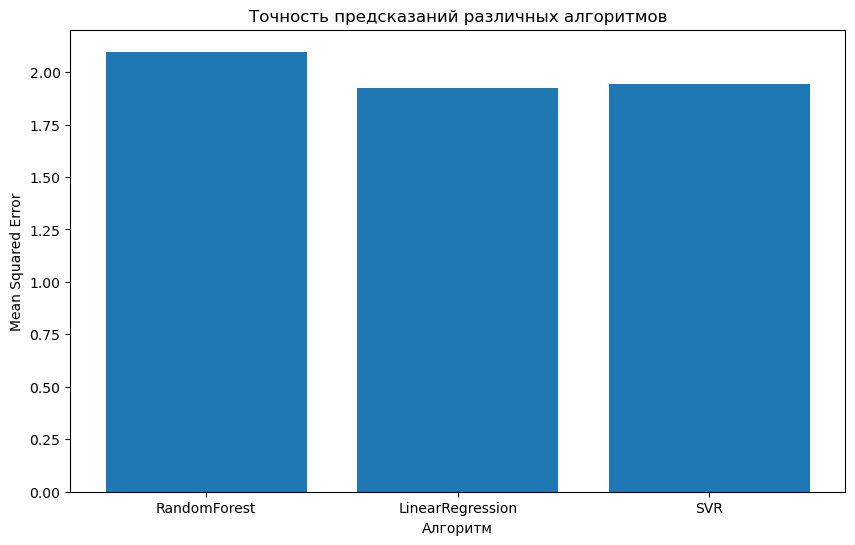

In [1]:
import pandas as pd
from docx import Document
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Загрузка данных
file_path = 'students_data#.csv'
data = pd.read_csv(file_path, delimiter=',')

# Требуется задать ID ученика для которого строится ИУП
student_id = 1345
student_data = data[data['ID'] == student_id].iloc[0]

def define_level(score):
    if score >= 4:
        return 'Углубленный'
    elif score >= 3:
        return 'Базовый'
    else:
        return 'Начальный'

subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)

def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}

student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))

extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}

for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1

for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)

class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]

additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}

iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)

doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

# Обучение моделей и оценка точности
features = ['Уровень тревожности (1-10)', 'Пропуски занятий', 'Средний балл', 'Когнитивные способности', 'Результаты анкет']
target = 'Оценка отношений с учителями (1-5)'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracies[name] = mse

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Точность предсказаний различных алгоритмов')
plt.xlabel('Алгоритм')
plt.ylabel('Mean Squared Error')
plt.show()

In [1]:
import pandas as pd
from docx import Document

file_path = 'students_data#.csv'
data = pd.read_csv(file_path, delimiter=',')

# Требуется задать ID ученика для которого строится ИУП
student_id = 1345
student_data = data[data['ID'] == student_id].iloc[0]

def define_level(score):
    if score >= 4:
        return 'Углубленный'
    elif score >= 3:
        return 'Базовый'
    else:
        return 'Начальный'
subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [2]:
file_path = 'students_data#.csv'
data = pd.read_csv(file_path, delimiter=',')

# Требуется задать ID ученика для которого строится ИУП
student_id = 1345
student_data = data[data['ID'] == student_id].iloc[0]

def define_level(score):
    if score >= 4:
        return 'Углубленный'
    elif score >= 3:
        return 'Базовый'
    else:
        return 'Начальный'
subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [3]:
# Требуется задать ID ученика для которого строится ИУП
student_id = 1345
student_data = data[data['ID'] == student_id].iloc[0]

def define_level(score):
    if score >= 4:
        return 'Углубленный'
    elif score >= 3:
        return 'Базовый'
    else:
        return 'Начальный'
subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [4]:
def define_level(score):
    if score >= 4:
        return 'Углубленный'
    elif score >= 3:
        return 'Базовый'
    else:
        return 'Начальный'
subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [5]:
subjects = [col for col in data.columns if col not in ['ID', 'Класс', 'Пол', 'Уровень тревожности (1-10)', 'Пропуски занятий', 
                                                      'Оценка отношений с учителями (1-5)', 'Возраст', 'Когнитивные способности', 
                                                      'Результаты анкет', 'Средний балл', 'Диагностика профиля способностей и достижений', 
                                                      'Сильные стороны', 'Слабые стороны']]
levels = {subject: define_level(student_data[subject]) for subject in subjects if not pd.isna(student_data[subject])}

iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [6]:
iup = {
    'Обязательные предметы': [],
    'Предметы углубленного уровня': [],
    'Предметы базового уровня': [],
    'Предметы начального уровня': [],
    'Дополнительные курсы и внеурочная деятельность': []
}

for subject, level in levels.items():
    if level == 'Углубленный':
        iup['Предметы углубленного уровня'].append(subject)
    elif level == 'Базовый':
        iup['Предметы базового уровня'].append(subject)
    else:
        iup['Предметы начального уровня'].append(subject)
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [7]:
def ai_model(student_data, subject):
    anxiety_level = student_data['Уровень тревожности (1-10)']
    performance = student_data[subject]
    
    if pd.isna(performance):
        performance = 3
    
    class_hours = max(0, 3 - int(anxiety_level / 4))
    individual_hours = max(0, int(anxiety_level / 4))
    
    if performance < 3:
        individual_hours += 1
    
    return {'в классе': class_hours, 'индивидуально': individual_hours}
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [8]:
student_class = student_data['Класс']
total_hours = 0
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [9]:
max_load = {
    5: 32,
    6: 33,
    7: 35,
    8: 36,
    9: 36
}
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [10]:
subject_schedules = []

for subject, level in levels.items():
    schedule = ai_model(student_data, subject)
    subject_schedules.append((subject, schedule['в классе'], schedule['индивидуально']))
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [11]:
extra_courses = {
    'Психология': [5, 6, 7, 8],
    'Основы военной подготовки': [5, 6, 7],
    'Русская словесность': [7, 8, 9],
    'Экологическая культура': [8, 9],
    'История Ставрополья': [5, 6, 7, 8]
}
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [12]:
for course, classes in extra_courses.items():
    if student_class in classes:
        iup['Дополнительные курсы и внеурочная деятельность'].append(f"{course} (1 ч.)")
        total_hours += 1
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [13]:
for i in range(len(subject_schedules)):
    subject, class_hours, individual_hours = subject_schedules[i]
    total_hours += class_hours + individual_hours
    
    if total_hours > max_load[student_class]:
        
        excess_hours = total_hours - max_load[student_class]
        reduction_ratio = excess_hours / (class_hours + individual_hours)
        
        class_hours -= int(class_hours * reduction_ratio)
        individual_hours -= int(individual_hours * reduction_ratio)
        
        total_hours = max_load[student_class]
    
    subject_schedules[i] = (subject, class_hours, individual_hours)
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [14]:
class_hours_total = sum(class_hours for _, class_hours, _ in subject_schedules)
individual_hours_total = sum(individual_hours for _, _, individual_hours in subject_schedules)

iup['Обязательные предметы'] = [f"{subject} ({class_hours} ч. в классе, {individual_hours} ч. индивидуально)" 
                                 for subject, class_hours, individual_hours in subject_schedules]
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [15]:
additional_info = {
    'ID': student_data['ID'],
    'Класс': student_data['Класс'],
    'Пол': student_data['Пол'],
    'Оценка отношений с учителями': student_data['Оценка отношений с учителями (1-5)'],
    'Возраст': student_data['Возраст'],
    'Когнитивные способности': student_data['Когнитивные способности'],
    'Результаты анкет': student_data['Результаты анкет'],
    'Диагностика профиля способностей и достижений': student_data['Диагностика профиля способностей и достижений'],
    'Всего часов': total_hours,
    'Часов в классе': class_hours_total,
    'Часов индивидуальных': individual_hours_total
}
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [16]:
iup_df = pd.DataFrame(dict([(k, pd.Series(v, dtype=object)) for k, v in iup.items()]))
iup_df = iup_df.assign(**additional_info)
iup_df.to_csv(f'ИУП_ученик_{student_id}.csv', index=False)
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [17]:
doc = Document()
doc.add_heading('Индивидуальный учебный план', 0)

for key, value in additional_info.items():
    doc.add_paragraph(f'{key}: {value}')

for key, value in iup.items():
    doc.add_heading(key, level=1)
    for item in value:
        doc.add_paragraph(item)

doc.save(f'ИУП_ученик_{student_id}.docx')

In [18]:
print(iup_df)

                                Обязательные предметы  \
0    Русский язык (1 ч. в классе, 3 ч. индивидуально)   
1      Литература (1 ч. в классе, 2 ч. индивидуально)   
2   Иностранный язык (1 ч. в классе, 2 ч. индивиду...   
3         Алгебра (1 ч. в классе, 2 ч. индивидуально)   
4       Геометрия (1 ч. в классе, 2 ч. индивидуально)   
5     Информатика (1 ч. в классе, 2 ч. индивидуально)   
6   История России (1 ч. в классе, 2 ч. индивидуал...   
7   Всеобщая история (1 ч. в классе, 2 ч. индивиду...   
8   Обществознание (1 ч. в классе, 2 ч. индивидуал...   
9       География (1 ч. в классе, 2 ч. индивидуально)   
10         Физика (1 ч. в классе, 2 ч. индивидуально)   
11          Химия (0 ч. в классе, 0 ч. индивидуально)   
12       Биология (0 ч. в классе, 0 ч. индивидуально)   
13     Технология (0 ч. в классе, 0 ч. индивидуально)   
14  Основы безопасности жизнедеятельности (0 ч. в ...   
15  Физическая культура (0 ч. в классе, 0 ч. индив...   

   Предметы углубленного уровн